<a href="https://colab.research.google.com/github/lauren1turner/DS4002_LAM/blob/project2/Time_series_not_used_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd

# Load the datasets
co = pd.read_csv("Daily_Avg_CO (1).csv", parse_dates=["Date"])
ozone = pd.read_csv("Daily_Avg_Ozone (1).csv", parse_dates=["Date"])
pm10 = pd.read_csv("Daily_Avg_PM10 (1).csv", parse_dates=["Date"])
pm25 = pd.read_csv("Daily_Avg_PM2.5 (1).csv", parse_dates=["Date"])


In [14]:
pm25.head()

,Date,Daily Mean PM2.5 Concentration,date
0,2022-01-01,17.081250,2022-01-01
1,2022-01-02,7.857143,2022-01-02
2,2022-01-03,11.275000,2022-01-03
3,2022-01-04,15.300000,2022-01-04
4,2022-01-05,20.616000,2022-01-05


In [18]:
# Remove extra spaces from column names
co.columns = co.columns.str.strip()
ozone.columns = ozone.columns.str.strip()
pm10.columns = pm10.columns.str.strip()
pm25.columns = pm25.columns.str.strip()

# Drop duplicate 'Date' columns, keeping the first one
co = co.loc[:, ~co.columns.duplicated()]
ozone = ozone.loc[:, ~ozone.columns.duplicated()]
pm10 = pm10.loc[:, ~pm10.columns.duplicated()]
pm25 = pm25.loc[:, ~pm25.columns.duplicated()]


#merge the data

In [19]:
# Ensure column names are consistent
co.rename(columns={"date": "Date", "Daily Max 8-hour CO Concentration": "CO"}, inplace=True)
ozone.rename(columns={"date": "Date", "Daily Max 8-hour Ozone Concentration": "Ozone"}, inplace=True)
pm10.rename(columns={"date": "Date", "Daily Mean PM10 Concentration	": "PM10"}, inplace=True)
pm25.rename(columns={"date": "Date", "Daily Mean PM2.5 Concentration": "PM2.5"}, inplace=True)


<ipython-input-19-4822e070e055>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  co.rename(columns={"date": "Date", "Daily Max 8-hour CO Concentration": "CO"}, inplace=True)
<ipython-input-19-4822e070e055>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ozone.rename(columns={"date": "Date", "Daily Max 8-hour Ozone Concentration": "Ozone"}, inplace=True)
<ipython-input-19-4822e070e055>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p

In [20]:
# Merge datasets on 'Date'
df = co.merge(ozone, on="Date", how="inner") \
       .merge(pm10, on="Date", how="inner") \
       .merge(pm25, on="Date", how="inner")

In [23]:
# Set 'Date' as index and resample
df.set_index("Date", inplace=True)
df = df.resample('D').mean()

# Display the first few rows


KeyError: "None of ['Date'] are in the columns"

In [24]:
print(df.head())


                  CO     Ozone  Daily Mean PM10 Concentration      PM2.5
Date                                                                    
2022-01-01  0.542857  0.037067                      21.166667  17.081250
2022-01-02  0.621429  0.036312                      14.833333   7.857143
2022-01-03  0.728571  0.029437                      25.400000  11.275000
2022-01-04  0.842857  0.027187                      28.800000  15.300000
2022-01-05  1.028571  0.024375                      34.000000  20.616000


#VAR model

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_absolute_error

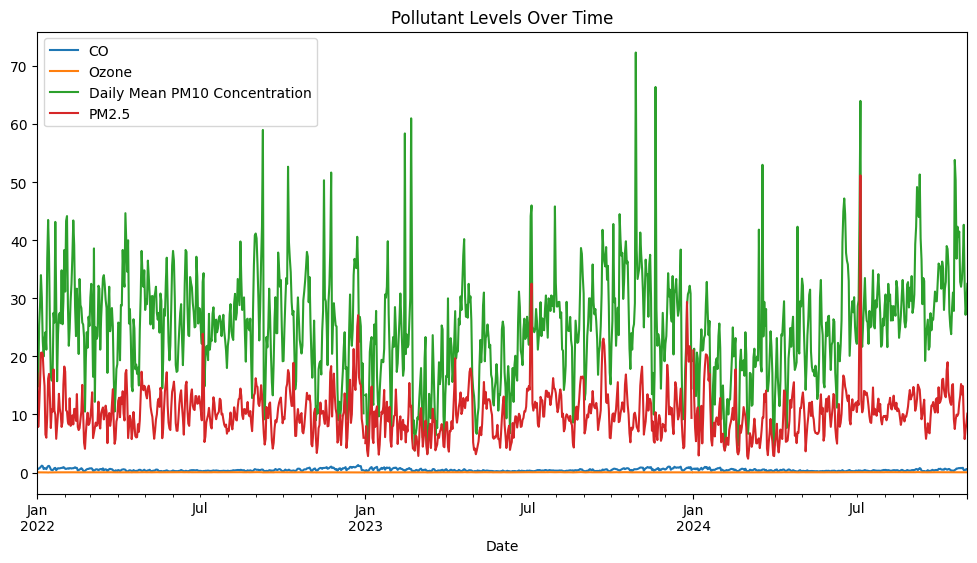

In [26]:
df.plot(figsize=(12, 6), title="Pollutant Levels Over Time")
plt.show()

#Check for stationarity

In [27]:
def check_stationarity(series):
    result = adfuller(series.dropna())
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] > 0.05:
        print("Data is non-stationary. Differencing needed.")
    else:
        print("Data is stationary.")

# Check for each pollutant
for col in df.columns:
    print(f"Stationarity Test for {col}:")
    check_stationarity(df[col])
    print("\n")


Stationarity Test for CO:
ADF Statistic: -3.0620691724393834
p-value: 0.029490582535519096
Data is stationary.


Stationarity Test for Ozone:
ADF Statistic: -2.437770116188462
p-value: 0.13135853880678933
Data is non-stationary. Differencing needed.


Stationarity Test for Daily Mean PM10 Concentration:
ADF Statistic: -5.238251705811182
p-value: 7.341382376716213e-06
Data is stationary.


Stationarity Test for PM2.5:
ADF Statistic: -12.522276708951242
p-value: 2.5329789848454613e-23
Data is stationary.




Ozone is non-stationary, first order differencing

In [28]:
df_diff = df.diff().dropna()

Select Optimal Lag Order

In [29]:
model = VAR(df_diff)
lag_order = model.select_order(maxlags=15)
print(lag_order.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -8.538      -8.519   0.0001958      -8.531
1       -8.624      -8.527   0.0001797      -8.587
2       -8.857      -8.683   0.0001423      -8.791
3       -8.930      -8.678   0.0001324      -8.834
4       -9.042     -8.713*   0.0001183      -8.917
5       -9.104      -8.697   0.0001112      -8.949
6       -9.134      -8.650   0.0001079     -8.950*
7       -9.149      -8.587   0.0001063      -8.936
8       -9.163      -8.523   0.0001048      -8.920
9       -9.181      -8.464   0.0001030      -8.909
10      -9.181      -8.386   0.0001030      -8.879
11      -9.163      -8.291   0.0001048      -8.832
12      -9.177      -8.227   0.0001034      -8.817
13      -9.188      -8.161   0.0001023      -8.798
14      -9.201      -8.096   0.0001010      -8.782
15     -9.202*      -8.020  0.0001009*      -8.753
-------------------------------

Train the VAR Model

In [30]:
optimal_lag = lag_order.aic  # Use AIC-selected lag
model_fitted = model.fit(optimal_lag)

# Print model summary
print(model_fitted.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 18, Mar, 2025
Time:                     15:27:15
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -8.01964
Nobs:                     1016.00    HQIC:                  -8.75302
Log likelihood:          -847.905    FPE:                0.000100887
AIC:                     -9.20209    Det(Omega_mle):     7.99000e-05
--------------------------------------------------------------------
Results for equation CO
                                       coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------------
const                                    -0.001266         0.003412           -0.371           0.711
L1.CO                                    -0.249786         0.036368           -6.868

make predictions

In [31]:
# Get the last observation to start forecasting
input_data = df_diff.values[-optimal_lag:]

# Forecast next 7 days
forecast = model_fitted.forecast(y=input_data, steps=7)

# Convert to DataFrame
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=df.index[-1], periods=7, freq="D"), columns=df.columns)

# Reverse differencing to get actual predicted values
forecast_df = df.iloc[-1] + forecast_df.cumsum()

# Display Predictions
print(forecast_df)


                  CO     Ozone  Daily Mean PM10 Concentration      PM2.5
2024-11-01  0.508314  0.046540                      29.974351   8.904052
2024-11-02  0.537285  0.050358                      34.490012   9.942612
2024-11-03  0.647618  0.052720                      38.677035  11.104056
2024-11-04  0.717532  0.053634                      40.471861  11.933895
2024-11-05  0.705860  0.052508                      37.705945  11.826796
2024-11-06  0.666570  0.051727                      33.007283  10.723695
2024-11-07  0.660314  0.052080                      35.012479  10.902565


compare predictions versus actual

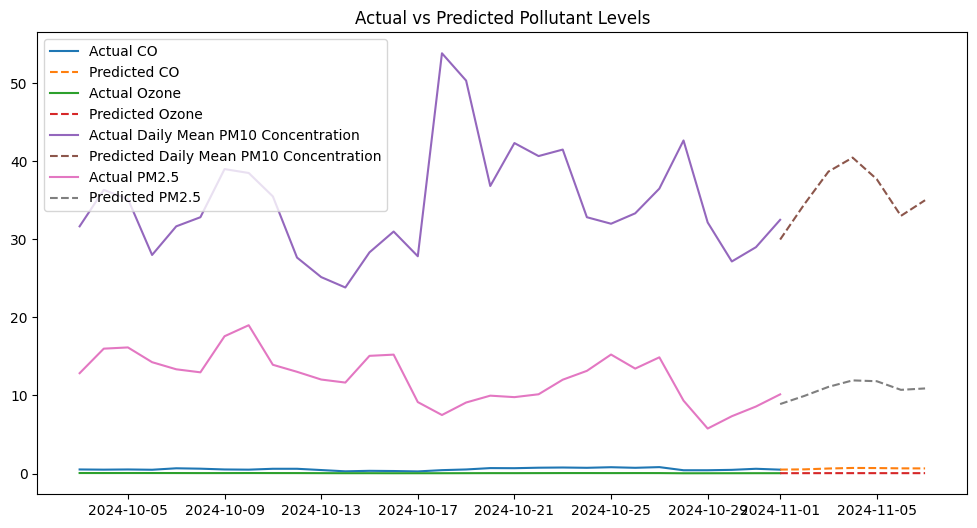

In [32]:
plt.figure(figsize=(12, 6))
for col in df.columns:
    plt.plot(df.index[-30:], df[col].iloc[-30:], label=f"Actual {col}")
    plt.plot(forecast_df.index, forecast_df[col], linestyle="dashed", label=f"Predicted {col}")

plt.legend()
plt.title("Actual vs Predicted Pollutant Levels")
plt.show()


In [33]:
# Compute MAE for each pollutant
for col in df.columns:
    actual_values = df[col].iloc[-7:]
    predicted_values = forecast_df[col]
    mae = mean_absolute_error(actual_values, predicted_values)
    print(f"MAE for {col}: {mae:.2f}")


MAE for CO: 0.21
MAE for Ozone: 0.01
MAE for Daily Mean PM10 Concentration: 4.96
MAE for PM2.5: 3.54


Now try to compare the forecast for two months of data

In [34]:
from datetime import timedelta

# Define the cutoff date (last two months)
cutoff_date = df.index[-1] - timedelta(days=60)

# Train on data before the cutoff date
train_df = df.loc[df.index <= cutoff_date]

# Test on the last two months
test_df = df.loc[df.index > cutoff_date]

print(f"Training data: {train_df.shape}")
print(f"Testing data: {test_df.shape}")


Training data: (976, 4)
Testing data: (60, 4)


Check for Stationarity & Apply Differencing

In [35]:
from statsmodels.tsa.stattools import adfuller

# Function to check stationarity
def check_stationarity(series):
    result = adfuller(series.dropna())
    return result[1]  # p-value

# Apply differencing if needed
if any(check_stationarity(train_df[col]) > 0.05 for col in train_df.columns):
    train_df = train_df.diff().dropna()
    test_df = test_df.diff().dropna()  # Ensure test set is also differenced


fit the VAR model

In [36]:
from statsmodels.tsa.vector_ar.var_model import VAR

# Find the optimal lag order using AIC
model = VAR(train_df)
lag_order = model.select_order(maxlags=15)  # Select best lag
optimal_lag = lag_order.aic
print(f"Optimal lag order: {optimal_lag}")

# Fit the model
model_fitted = model.fit(optimal_lag)


Optimal lag order: 14


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


make predicitons

In [37]:
# Prepare input data for forecasting (last observations from training set)
input_data = train_df.values[-optimal_lag:]

# Forecast for the same length as the test set
num_forecast_steps = len(test_df)
forecast = model_fitted.forecast(y=input_data, steps=num_forecast_steps)

# Convert to DataFrame
forecast_df = pd.DataFrame(forecast, index=test_df.index, columns=df.columns)

# Reverse differencing if needed
forecast_df = df.iloc[-num_forecast_steps - 1] + forecast_df.cumsum()

# Show predictions
print(forecast_df.head())


                  CO     Ozone  Daily Mean PM10 Concentration      PM2.5
Date                                                                    
2024-09-04  0.413921  0.056666                      32.541366  12.968246
2024-09-05  0.388176  0.054230                      31.346768  11.291706
2024-09-06  0.427153  0.052527                      31.722961  10.524254
2024-09-07  0.440642  0.051726                      32.423857  10.534199
2024-09-08  0.426272  0.052155                      29.963458  10.567731


compare

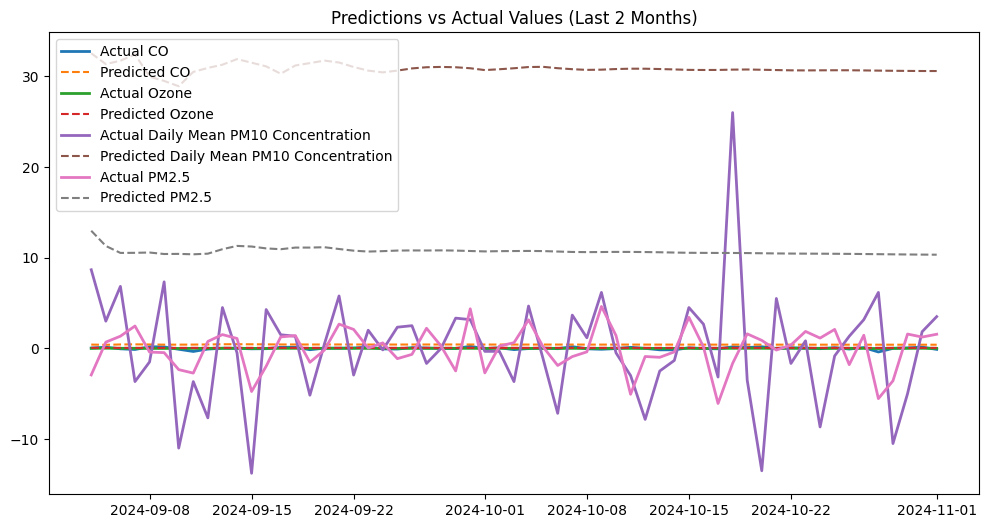

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for col in df.columns:
    plt.plot(test_df.index, test_df[col], label=f"Actual {col}", linewidth=2)
    plt.plot(forecast_df.index, forecast_df[col], linestyle="dashed", label=f"Predicted {col}")

plt.legend()
plt.title("Predictions vs Actual Values (Last 2 Months)")
plt.show()


calc MAE

In [39]:
from sklearn.metrics import mean_absolute_error

for col in df.columns:
    mae = mean_absolute_error(test_df[col], forecast_df[col])
    print(f"MAE for {col}: {mae:.2f}")


MAE for CO: 0.42
MAE for Ozone: 0.05
MAE for Daily Mean PM10 Concentration: 30.83
MAE for PM2.5: 10.76


In [40]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE and MAE % for each pollutant
for col in df.columns:
    mae = mean_absolute_error(test_df[col], forecast_df[col])
    data_range = test_df[col].max() - test_df[col].min()

    # Avoid division by zero
    if data_range == 0:
        mae_percent = 0
    else:
        mae_percent = (mae / data_range) * 100

    print(f"{col} - MAE: {mae:.2f}, MAE%: {mae_percent:.2f}%")


CO - MAE: 0.42, MAE%: 66.58%
Ozone - MAE: 0.05, MAE%: 142.34%
Daily Mean PM10 Concentration - MAE: 30.83, MAE%: 77.51%
PM2.5 - MAE: 10.76, MAE%: 100.54%


MAE is very high. Consdier ways to tune the model.

Check for stationarity and apply differencing

In [41]:
from statsmodels.tsa.stattools import adfuller

# Function to check stationarity
def check_stationarity(series):
    result = adfuller(series.dropna())
    return result[1]  # p-value

# Apply differencing if needed
for col in train_df.columns:
    if check_stationarity(train_df[col]) > 0.05:  # p-value > 0.05 means non-stationary
        train_df[col] = train_df[col].diff().dropna()
        test_df[col] = test_df[col].diff().dropna()  # Apply same transformation to test data


Tune lag selection

In [42]:
from statsmodels.tsa.api import VAR

# Test different lags
best_mae = float("inf")
best_lag = None

for lag in range(1, 21):  # Try lags from 1 to 20
    model = VAR(train_df)
    model_fitted = model.fit(lag)

    # Forecast
    forecast = model_fitted.forecast(train_df.values[-lag:], steps=len(test_df))
    forecast_df = pd.DataFrame(forecast, index=test_df.index, columns=df.columns)

    # Calculate MAE
    mae = mean_absolute_error(test_df, forecast_df)

    if mae < best_mae:
        best_mae = mae
        best_lag = lag

print(f"Best Lag: {best_lag}, Best MAE: {best_mae:.2f}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Best Lag: 5, Best MAE: 1.54


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Try a Different Model (LSTM or XGBoost)

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build an LSTM model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(lag, len(df.columns))),
    LSTM(50, activation='relu'),
    Dense(len(df.columns))
])

model.compile(optimizer='adam', loss='mae')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Use SARIMAX (SARIMA with Exogenous Variables)

In [47]:
train_df.rename(columns={"Daily Mean PM10 Concentration": "PM10"}, inplace=True)


In [49]:
print(train_df.columns)  # See the actual column names


Index(['CO', 'Ozone', 'PM10', 'PM2.5'], dtype='object')


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


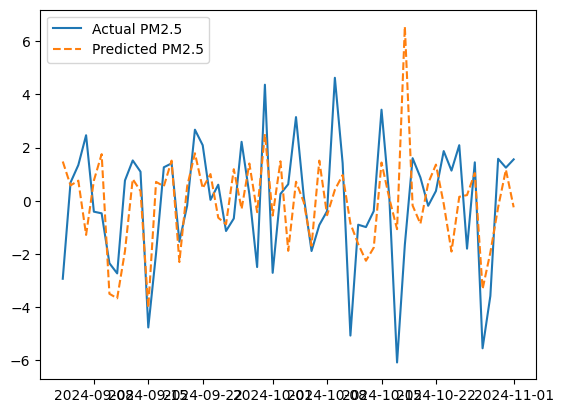

In [50]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit a SARIMAX model for PM2.5 using CO, Ozone, and PM10 as exogenous variables
model = SARIMAX(train_df['PM2.5'],
                exog=train_df[['CO', 'Ozone', 'PM10']],
                order=(2,1,2),
                seasonal_order=(1,1,1,12))

model_fitted = model.fit()

# Forecast using test data exogenous variables
forecast = model_fitted.predict(start=len(train_df),
                                end=len(train_df) + len(test_df) - 1,
                                exog=test_df[['CO', 'Ozone', "Daily Mean PM10 Concentration"]])

# Compare with actual PM2.5
plt.plot(test_df.index, test_df['PM2.5'], label="Actual PM2.5")
plt.plot(test_df.index, forecast, label="Predicted PM2.5", linestyle="dashed")
plt.legend()
plt.show()


MAE for SARIMAX

In [51]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE
mae = mean_absolute_error(test_df['PM2.5'], forecast)

# Print MAE
print(f"Mean Absolute Error (MAE): {mae:.2f}")


Mean Absolute Error (MAE): 1.69


Compute accuracy score

In [52]:
# Get the range of actual values (max - min)
range_pm25 = test_df['PM2.5'].max() - test_df['PM2.5'].min()

# Compute accuracy
accuracy = (1 - (mae / range_pm25)) * 100

# Print accuracy
print(f"Accuracy of SARIMAX forecast: {accuracy:.2f}%")


Accuracy of SARIMAX forecast: 84.22%


SARIMAX for other pollutants

In [60]:
# Define split point (last two months for testing)
split_index = int(len(df) - 60)  # Assuming ~30 days per month

# Training Data (exclude last two months)
train_df = df.iloc[:split_index]

# Testing Data (last two months)
test_df = df.iloc[split_index:]


In [64]:
train_df.head()

,CO,Ozone,Daily Mean PM10 Concentration,PM2.5
Date,,,,
2022-01-01,0.542857,0.037067,21.166667,17.081250
2022-01-02,0.621429,0.036312,14.833333,7.857143
2022-01-03,0.728571,0.029437,25.400000,11.275000
2022-01-04,0.842857,0.027187,28.800000,15.300000
2022-01-05,1.028571,0.024375,34.000000,20.616000


In [66]:
print(train_df[['CO', 'Ozone', 'PM2.5']].isna().sum())  # Count missing values
print(train_df[['CO', 'Ozone', 'PM2.5']].info())  # Check data types


CO       2
Ozone    2
PM2.5    2
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 976 entries, 2022-01-01 to 2024-09-02
Freq: D
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO      974 non-null    float64
 1   Ozone   974 non-null    float64
 2   PM2.5   974 non-null    float64
dtypes: float64(3)
memory usage: 30.5 KB
None


In [68]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define SARIMAX Model
model_pm10 = SARIMAX(train_df['Daily Mean PM10 Concentration'],
                      exog=train_df[['CO', 'Ozone', 'PM2.5']],
                      order=(2,1,2),  # (p,d,q) - Can be optimized
                      seasonal_order=(1,1,1,12))  # (P,D,Q,s) - Seasonal component

# Fit the model
model_fitted_pm10 = model_pm10.fit()

# Print summary
print(model_fitted_pm10.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:        Daily Mean PM10 Concentration   No. Observations:                  976
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -3009.947
Date:                              Tue, 18 Mar 2025   AIC                           6039.895
Time:                                      15:59:11   BIC                           6088.595
Sample:                                  01-01-2022   HQIC                          6058.438
                                       - 09-02-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CO             9.2218      1.466      6.290      0.000       6.348      12.095
Ozone         44.30

In [67]:
train_df[['CO', 'Ozone', 'PM2.5']] = train_df[['CO', 'Ozone', 'PM2.5']].fillna(method="ffill")


<ipython-input-67-7fa4f34096e7>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df[['CO', 'Ozone', 'PM2.5']] = train_df[['CO', 'Ozone', 'PM2.5']].fillna(method="ffill")
<ipython-input-67-7fa4f34096e7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[['CO', 'Ozone', 'PM2.5']] = train_df[['CO', 'Ozone', 'PM2.5']].fillna(method="ffill")


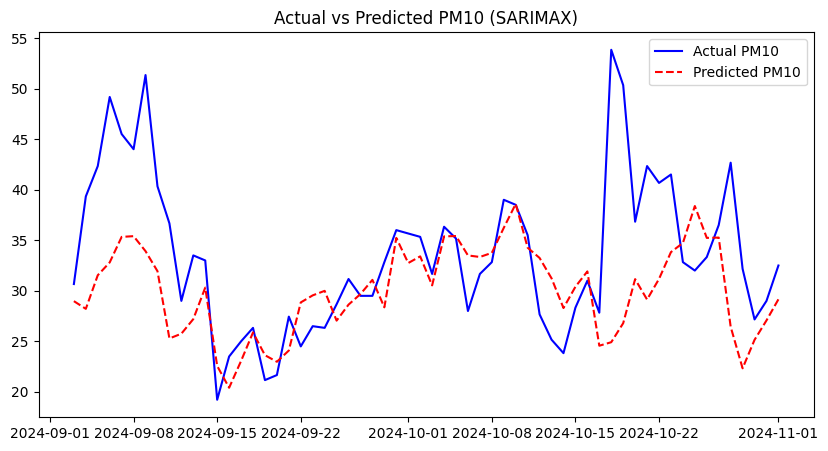

In [70]:
# Forecast using test exogenous variables
forecast_pm10 = model_fitted_pm10.predict(start=len(train_df),
                                          end=len(train_df) + len(test_df) - 1,
                                          exog=test_df[['CO', 'Ozone', 'PM2.5']])

# Ensure forecast index matches test data
forecast_pm10 = pd.Series(forecast_pm10.values, index=test_df.index)

# Plot Actual vs. Predicted PM10
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(test_df.index, test_df['Daily Mean PM10 Concentration'], label="Actual PM10", color='blue')
plt.plot(test_df.index, forecast_pm10, label="Predicted PM10", linestyle="dashed", color='red')
plt.legend()
plt.title("Actual vs Predicted PM10 (SARIMAX)")
plt.show()


In [73]:
from sklearn.metrics import mean_absolute_error

# Compute MAE
mae_pm10 = mean_absolute_error(test_df['Daily Mean PM10 Concentration'], forecast_pm10)

# Compute accuracy as a percentage of the range
range_pm10 = test_df['Daily Mean PM10 Concentration'].max() - test_df['Daily Mean PM10 Concentration'].min()
accuracy_pm10 = (1 - (mae_pm10 / range_pm10)) * 100

# Print results
print(f"Mean Absolute Error (MAE) for PM10: {mae_pm10:.2f}")
print(f"Accuracy of SARIMAX forecast for PM10: {accuracy_pm10:.2f}%")


Mean Absolute Error (MAE) for PM10: 5.36
Accuracy of SARIMAX forecast for PM10: 84.53%
